In [14]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from collections import defaultdict
from functools import reduce
from path import Path
from pprint import pprint

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 16,6


In [15]:
from sampling import dollar_bars
from filters import cusum
from multiprocess import mpPandasObj
from load_data import load_contracts
from labeling import getEvents, getVerticalBarriers, getBins
from util import getDailyVol

In [16]:
es_contracts = load_contracts('@ES')

# 4.1a

In Chapter 3, we denoted as `t1` a pandas series of timestamps where the first barrier was touched, and the index was the timestamp of the observation. This was the output of the `getEvents` function.

Compute a `t1` series on dollar bars derived from E-mini S&P 500 futures tick data.

In [17]:
dbars = dollar_bars(es_contracts, 100000000)
close = dbars['Close']
daily_vol = getDailyVol(close)
filtered_bars = cusum(close, daily_vol.mean())
trip_barr_events = getEvents(dbars['Close'], filtered_bars, ptSl=[1,1], trgt=daily_vol, minRet=0.01)


In [18]:
trip_barr_events.head()

,t1,trgt,pt,sl
2016-11-30 11:09:00,2016-12-07 13:40:00,0.012111,1,1
2018-02-05 10:28:00,2018-02-05 13:02:00,0.010232,1,1
2018-02-05 10:34:00,2018-02-05 13:09:00,0.010271,1,1
2018-02-05 10:54:00,2018-02-05 13:02:00,0.010475,1,1
2018-02-05 11:01:00,2018-02-05 13:05:00,0.010512,1,1


# 4.1b

In Chapter 3, we denoted as `t1` a pandas series of timestamps where the first barrier was touched, and the index was the timestamp of the observation. This was the output of the `getEvents` function.

Apply the function `mpNumCoEvents` to compute the number of overlapping outcomes at each point in time.

In [19]:
def mpNumCoEvents(closeIdx, t1, molecule):
    '''
    Compute the number of concurrent events per bar.
    +molecule[0] is the date of the first event on which the weight will be computed
    +molecule[-1] is the date of the last event on which the weight will be computed
    Any event that starts before t1[molecule].max() impacts the count.
    '''
    # 1) find events that span the period [molecule[0], molecule[-1]]
    t1 = t1.fillna(closeIdx[-1]) # unclosed events still must impact other weights
    t1 = t1[t1 >= molecule[0]] # events that end at or after molecule[0]
    t1 = t1.loc[:t1[molecule].max()] # events that start at or before t1[molecule].max()
    # 2) count events spanning a bar
    iloc = closeIdx.searchsorted(np.array([t1.index[0], t1.max()]))
    count = pd.Series(0, index=closeIdx[iloc[0]:iloc[1]+1])
    for tIn, tOut in t1.iteritems():
        count.loc[tIn:tOut] += 1.0
    return count.loc[molecule[0]:t1[molecule].max()]

conc_events = mpNumCoEvents(filtered_bars, trip_barr_events['t1'], filtered_bars)
    

# 4.1c

In Chapter 3, we denoted as `t1` a pandas series of timestamps where the first barrier was touched, and the index was the timestamp of the observation. This was the output of the `getEvents` function.

Plot the time series of the number of concurrent labels on the primary axis, and the time series of the exponentially weigthed moving standard deviation of returns on the secondary axis.

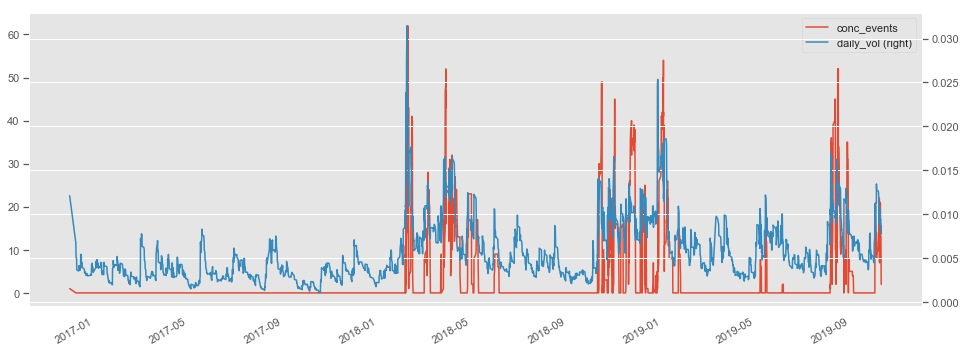

In [20]:
to_plot = pd.DataFrame({'conc_events': conc_events, 'daily_vol':daily_vol}).dropna()
to_plot.plot(secondary_y='daily_vol');

# 4.1d

In Chapter 3, we denoted as `t1` a pandas series of timestamps where the first barrier was touched, and the index was the timestamp of the observation. This was the output of the `getEvents` function.

Produce a scatterplot of the number of concurrent labels (x-axis) and the exponentially weigthed moving standard deviation of returns (y-axis). Can you appreciate a relationship?

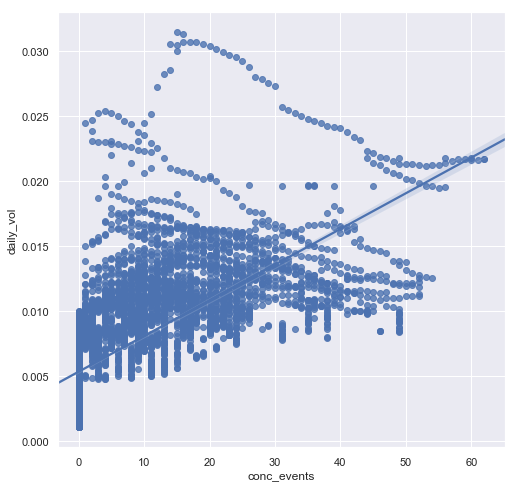

In [21]:
import seaborn as sns
sns.set(rc={'figure.figsize':(8, 8)})

sns.regplot(to_plot['conc_events'], y=to_plot['daily_vol']);

**A: It does appear I may appreciate a positive relationship between volatility and number of concurrent bars.**

# 4.2

Using the function `mpSampleTW`, compute the average uniqueness of each label. What is the first-order serial correlation, AR(1) of the time series? Is it statistically significant? Why?


In [22]:
def mpSampleTW(t1, numCoEvents, molecule):
    # Derive average uniqueness over the event's lifespan
    wght = pd.Series(index=molecule)
    for tIn, tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn] = (1.0 / numCoEvents.loc[tIn:tOut]).mean()
    return wght

In [23]:
uniqueness = mpSampleTW(trip_barr_events['t1'], conc_events, filtered_bars)

C:\Users\doda\Anaconda3\envs\zippy\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.


In [24]:
uniqueness.autocorr()

0.8320100146512703

The lag 1 autocorrelation is 0.83. The critical values at the 5 % significance level are -0.140 and 0.140. This indicates that the lag 1 autocorrelation is statistically significant.



# 4.3a

Fit a random forrest to a financial dataset where $I^{-1} \sum_{i=1}^I \bar u_i \ll 1$

What is the mean out-of-bag accuracy?

In [25]:
# Note: We're already defining a few things that we'll need for later

df = dbars.copy()['2018-8-1':'2019-5-1']
tEvents = cusum(df['Close'], getDailyVol(df['Close']).mean())
t1 = getVerticalBarriers(df['Close'], tEvents, numDays=1)
events = getEvents(close, tEvents=tEvents, ptSl=[1,1], t1=t1, trgt=daily_vol, minRet=0.01)

In [26]:
close = df['Close']
fast_ma = close.rolling(50).mean()
slow_ma = close.rolling(200).mean()

long_signals = (fast_ma >= slow_ma)
short_signals = (fast_ma < slow_ma)

df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1
events['side'] = df['side']

bins = getBins(events, df['Close'])
bins['bin'].value_counts()

0    490
1    209
Name: bin, dtype: int64

In [27]:
# We'll use the features described in 3.5b (vol, serial corr., ma crosses)
df['log_ret'] = np.log(close).diff()
df['vol5'] = df['log_ret'].rolling(5).std()
df['vol10'] = df['log_ret'].rolling(10).std()

df['serialcorr20-1'] = df['log_ret'].rolling(20).apply(lambda x: pd.Series(x).autocorr(lag=1))


df = df.shift()

In [28]:
from sklearn.ensemble import RandomForestClassifier

train_features = df.loc[events.index][['side', 'vol5', 'serialcorr20-1']]
train_labels = bins['bin']

rf = RandomForestClassifier(n_estimators=512, random_state=42, max_depth=5, oob_score=True)
rf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=512, n_jobs=None,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [29]:
print("The Score of the training dataset obtained using an out-of-bag estimate is %.3f." % rf.oob_score_)

The Score of the training dataset obtained using an out-of-bag estimate is 0.705.


# 4.3b

Fit a random forrest to a financial dataset where $I^{-1} \sum_{i=1}^I \bar u_i \ll 1$

What is the mean accuracy of k-fold cross-validation (without shuffling) on the same dataset?

In [30]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = train_features
y = train_labels

kfold = KFold(n_splits=2)
accuracies = []
for train_index, test_index in kfold.split(X):
    rf.fit(X.iloc[train_index], y.iloc[train_index])
    y_pred = rf.predict(X.iloc[test_index])
    accuracies.append(accuracy_score(y.iloc[test_index], y_pred))
    
print("Confusion matrix:")
print(confusion_matrix(y.iloc[test_index], y_pred))
print()
print("Original report:")
print(classification_report(y.iloc[test_index], y_pred))
print()
print("The mean accuracy of k-fold cross-validation is %.3f." % np.mean(accuracies))


Confusion matrix:
[[239   4]
 [103   3]]

Original report:
              precision    recall  f1-score   support

           0       0.70      0.98      0.82       243
           1       0.43      0.03      0.05       106

   micro avg       0.69      0.69      0.69       349
   macro avg       0.56      0.51      0.44       349
weighted avg       0.62      0.69      0.59       349


The mean accuracy of k-fold cross-validation is 0.690.


# 4.3c

Fit a random forrest to a financial dataset where $I^{-1} \sum_{i=1}^I \bar u_i \ll 1$

Why is the out-of-bag accuracy so much higher than cross-validation accuracy? Which one is more correct / less biased? What is the source of this bias?

**A: Random sampling makes it more likely for in-and-out-of-bag samples to be similar which inflates accuracy scores. We'll thusly assume K-Fold CV is less biased.**

# 4.4

Modify the code in Section 4.7 to apply an exponential time-decay factor.

In [ ]:
def getTimeDecay(tW, clfLastW=1.0):
    # apply piecewise-linear decay to observed uniqueness (tW)
    # newest observation gets weight=1, oldest observation gets weight clfLastW
    clfW = tW.sort_index().cumsum()
    if clfLastW >= 0:
        slope = (1.0 - clfLastW) / clfW.iloc[-1]
    else:
        slope = 1 / ((clfLastW + 1) * clfW.iloc[-1])
    const = 1.0 - slope * clfW.iloc[-1]
    clfW = const + slope * clfW
    clfW[clfW < 0] = 0
    print(const, slope)
    return clfW

#TODO: rewrite this
def get_time_decay_exp(tw, decay_rate=1.0, percent_of_zero_wts=0.):
    clf_w = tw.sort_index().cumsum()
    last_value = clf_w.iloc[-1]

    # create the output weights array
    out_wts = [0. if i < int(round(len(clf_w) * percent_of_zero_wts)) else np.exp((decay_rate - 1.) * (last_value - clf_w[i])) for i in np.arange(len(clf_w))]
    return pd.Series(np.asarray(out_wts))


# 4.5a

Consider you have applied meta-labels to events determined by a trend following model. Suppose that two thirds of the labels are 0 and one third of the labels are 1.

What happens if you fit a classifier without balancing class weights?

**A: The classifier will pay more attention to the majority labeled data, hurting accuracy on the minority labels.**

# 4.5b

Consider you have applied meta-labels to events determined by a trend following model. Suppose that two thirds of the labels are 0 and one third of the labels are 1.


A label 1 means a true positive, and a label 0 means a false positive. By applying balanced class weights, we are forcing the classifier to pay more attention to the true positives, and less attention to the false positives. Why does that make sense?

**A: Many machine learning algorithms are designed to maximize overall accuracy, and we thus want them to perform equally well on positive/negative labels.**

# 4.5c

Consider you have applied meta-labels to events determined by a trend following model. Suppose that two thirds of the labels are 0 and one third of the labels are 1.


What is the distribution of the predicted labels, before and after applying balanced class weights?

In [ ]:
print("-- Unbalanced class weights --")
print("Classification report:")
print(classification_report(y.iloc[test_index], y_pred))
print()
print("The mean accuracy of k-fold cross-validation is %.3f." % np.mean(accuracies))
print()
print("The distribution of labels:")
print(pd.Series(y_pred).value_counts(normalize=True))

In [ ]:
rf = RandomForestClassifier(
    n_estimators=512, random_state=42, max_depth=5, oob_score=True, class_weight='balanced_subsample')
rf.fit(train_features, train_labels)

kfold = KFold(n_splits=2)
accuracies = []
for train_index, test_index in kfold.split(X):
    rf.fit(X.iloc[train_index], y.iloc[train_index])
    y_pred = rf.predict(X.iloc[test_index])
    accuracies.append(accuracy_score(y.iloc[test_index], y_pred))


print("-- Balanced class weights --")
print("Confusion matrix:")
print(confusion_matrix(y.iloc[test_index], y_pred))
print()
print("Classification report:")
print(classification_report(y.iloc[test_index], y_pred))
print()
print("The mean accuracy of k-fold cross-validation is %.3f." % np.mean(accuracies))
print()
print("The distribution of labels:")
print(pd.Series(y_pred).value_counts(normalize=True))

**Recall of Positives increases substantially out-of-sample (0.15 -> 0.51), as a further benefit we're only filtering out 57% of signals rather than 88% like before, however overall accuracy dipped (0.65 -> 0.6).**

# 4.6

Update the draw for the final draw in Section 4.5.3

In [31]:
def getIndMatrix(barIx, t1):
    # Get indicator matrix
    indM = pd.DataFrame(0, index=barIx, columns=range(t1.shape[0]))
    for i, (t0, t1) in enumerate(t1.iteritems()):
        indM.loc[t0:t1, i] = 1.0
    return indM

def getAvgUniqueness(indM):
    # Average uniqueness from indicator matrix
    c = indM.sum(axis=1) # concurrency
    u = indM.div(c, axis=0) # uniqueness
    avgU = u[u>0].mean()
    return avgU

barIx = range(6)
tl = pd.Series([2, 3, 5], index=[0, 2, 4])
indM = getIndMatrix(barIx, tl)

picked = [1, 2]
averages = []
for i in indM:
    avgU = getAvgUniqueness(indM[picked + [i]])
    averages.append(avgU.iloc[-1])
averages = pd.Series(averages) / sum(averages)
print("Probabilities:")
print(averages)

Probabilities:
0    0.454545
1    0.272727
2    0.272727
dtype: float64


# 4.7

In Section 4.5.3 suppose that number 2 is picked again in the second draw. What would be the updated probabilites for the third draw?

In [32]:
picked = [1, 1]
averages = []
for i in indM:
    avgU = getAvgUniqueness(indM[picked + [i]])
    averages.append(avgU.iloc[-1])
averages = pd.Series(averages) / sum(averages)
print("Probabilities:")
print(averages)

Probabilities:
0    0.368421
1    0.157895
2    0.473684
dtype: float64
